Aca vamos a hacer la parte de generacion y evaluacion de modelos

In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,precision_score ,f1_score

In [65]:
df_trabajo = pd.read_csv("C:/Users/mlard/OneDrive/Escritorio/Mateo/Org de Datos/tp3Github/Org-Datos-Grupo-19/df_trabajo.csv", index_col=False)

In [66]:
df_trabajo.shape

(276572, 109)

In [67]:
df_trabajo.columns

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'D_43', 'D_44',
       'B_4',
       ...
       'D_127', 'D_128', 'B_41', 'D_130', 'R_28', 'D_139', 'D_140', 'D_144',
       'D_145', 'target'],
      dtype='object', length=109)

In [68]:
#Separo en train y test para trabajar los modelos
df_trabajo_x=df_trabajo.drop(['target'], axis='columns', inplace=False)

df_trabajo_y = df_trabajo['target'].copy()

x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x, df_trabajo_y, test_size=0.3, random_state=1)

Modelo Random forest

Vamos a ver cual criterio es mejor para predecir el modelo. Si el de gini o el de entropia

In [69]:
rfc1 = RandomForestClassifier(max_features='sqrt',random_state=2, n_jobs=-1,
                             n_estimators=50,
                             criterion="entropy", min_samples_leaf=5,min_samples_split=5 )
                            
model1 = rfc1.fit(X = x_train, y = y_train)
y_pred1 = model1.predict(x_test)
df_resultados1=pd.DataFrame(zip(y_test,y_pred1),columns=['real','predicted'])

accuracy1=accuracy_score(df_resultados1['real'], df_resultados1['predicted'], normalize=True)

In [70]:
rfc2 = RandomForestClassifier(max_features='sqrt',random_state=2, n_jobs=-1,
                             n_estimators=50,
                             criterion="gini", min_samples_leaf=5,min_samples_split=5 )
                            
model2 = rfc2.fit(X = x_train, y = y_train)
y_pred2 = model2.predict(x_test)
df_resultados2=pd.DataFrame(zip(y_test,y_pred1),columns=['real','predicted'])

accuracy2=accuracy_score(df_resultados2['real'], df_resultados2['predicted'], normalize=True)

In [71]:
if(accuracy1 > accuracy2):
    df_resultados_rfc = df_resultados1
    print('El criterio de entropia es mas efectivo')
elif (accuracy1 <= accuracy2): 
    df_resultados_rfc = df_resultados1
    print('El criterio de gini es mas efectivo')

El criterio de gini es mas efectivo


In [72]:
accuracy=accuracy_score(df_resultados_rfc['real'], df_resultados_rfc['predicted'], normalize=True)
print("Este modelo de Random forest tiene una accuracy del: " + str(round(accuracy, 5)) + "%")

Este modelo de Random forest tiene una accuracy del: 0.86818%


In [73]:
df_resultados_rfc.sample(5)

,real,predicted
16887,0.0,1.0
43381,0.0,0.0
46837,1.0,1.0
5608,0.0,0.0
71801,0.0,0.0


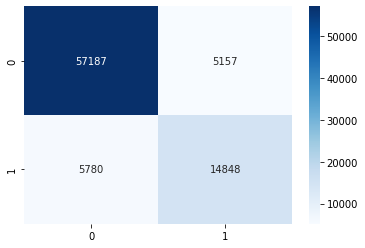

In [74]:
tabla=confusion_matrix(df_resultados_rfc['real'], df_resultados_rfc['predicted'])

grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

In [75]:
def results_comparation(df_predict):
    df_predict["success"] = (df_predict["real"] == df_predict["predicted"])
    df_predict["success"].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title("Cantidad de valores predecidos correctamente") 
    plt.show()

    precicion = precision_score(df_predict['real'], df_predict['predicted'])
    f1=f1_score(df_predict['real'], df_predict['predicted'])
    recall = recall_score(df_predict['real'], df_predict['predicted'])
    
    print(f"Precision score: \t{round(precicion,3)}")
    print(f"Recall score: \t\t{round(recall,3)}")
    print(f"F1 score: \t\t{round(f1,3)}")

    accuracy=accuracy_score(df_predict['real'], df_predict['predicted'], normalize=True)
    print("Tiene una accuracy del: " + str(round(accuracy, 3)) + "% como muestra el pie chart")


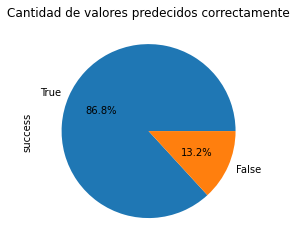

Precision score: 	0.742
Recall score: 		0.72
F1 score: 		0.731
Tiene una accuracy del: 0.868% como muestra el pie chart


In [76]:
results_comparation(df_resultados_rfc)

Modelo XGBoost

In [77]:
from scripts import featurizer_xgb
import xgboost as xgb
import sklearn
from xgboost.sklearn import XGBClassifier

In [78]:
# df_featurizado = featurizer_xgb.featurizer(df_trabajo)
df_featurizado = df_trabajo

In [79]:
X_xgb = df_featurizado.drop(axis = 1, columns = ['target'])
y_xgb = df_featurizado.target

features = X_xgb.columns

In [80]:
xgb = XGBClassifier()

In [81]:
#Set hyperparameters dictionary
param_dist = {'n_estimators':[50, 100],
              'max_depth':[5,10],              
              'subsample': [0.5,0.8,1],
              'colsample_bytree': [0.5,0.8,1],              
              'learning_rate':[0.01, 0.1, 0.3]
              }

In [82]:
random_search_xgb = RandomizedSearchCV(xgb,
                                       param_distributions = param_dist,
                                       n_iter = 2,
                                       scoring = 'roc_auc',
                                       cv = 5,
                                       n_jobs = -1,
                                       verbose=5)

In [83]:
%time
random_search_xgb.fit(x_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.8, 1],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [5, 10],
                                        'n_estimators': [50, 100],
                                        'subsample': [0.5, 0.8, 1]},
                   scoring='roc_auc', verbose=5)

In [84]:
params_opt_xgb = random_search_xgb.best_params_

In [85]:
params_opt_xgb

{'subsample': 0.8,
 'n_estimators': 50,
 'max_depth': 5,
 'learning_rate': 0.3,
 'colsample_bytree': 1}

In [86]:
xgbModelBestParams = XGBClassifier(**params_opt_xgb)

In [87]:
%time
model_xgb = xgbModelBestParams.fit(X = x_train,y = y_train)
y_pred_xgb = model_xgb.predict(x_test)
df_resultados_xgb=pd.DataFrame(zip(y_test,y_pred_xgb),columns=['real','predicted'])

CPU times: total: 0 ns
Wall time: 0 ns


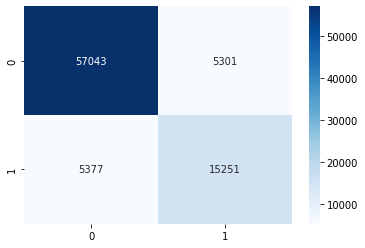

In [88]:
tabla=confusion_matrix(df_resultados_xgb['real'], df_resultados_xgb['predicted'])

grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

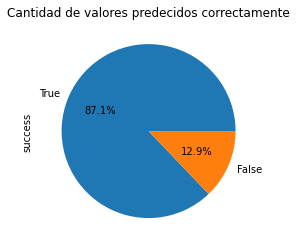

Precision score: 	0.742
Recall score: 		0.739
F1 score: 		0.741
Tiene una accuracy del: 0.871% como muestra el pie chart


In [89]:
results_comparation(df_resultados_xgb)

Suport Vector Machine

In [ ]:
from sklearn.svm import SVC

Ensamble de modelos

In [90]:
from sklearn.ensemble import VotingClassifier

In [91]:
rfc = RandomForestClassifier()


In [92]:
vot_clf = VotingClassifier(estimators = [('rnd', rfc),('xgb', xgb)], voting = 'hard')

In [93]:
vot_clf.fit(x_train, y_train)
pred = vot_clf.predict(x_test)
accuracy_score(y_test, pred)

0.8685098587475293